In [19]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import aim
import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython import display
import monai

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import scipy
import torch
import torch.nn.functional as F
import torchinfo
from box import Box
from icecream import ic
from lightning_fabric.fabric import Fabric
from natsort import natsorted

import pitn

# plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"image.interpolation": "nearest"})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import textwrap
import subprocess
import sys
import shlex
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from IPython import display

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import skimage
import scipy
import monai
import dipy
import torch
import torch.nn.functional as F
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

# plt.rcParams.update({"figure.autolayout": True})
# plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
# plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc

EnvironmentNameNotFound: Could not find conda environment: pitn
You can list all discoverable environments with `conda info --envs`.




True

In [3]:
# torch setup
# keep device as the cpu
device = torch.device("cpu")
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


## Directory & Data Loading

In [4]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

In [5]:
results_dir = Path("/data/srv/outputs/pitn/results/runs")
tmp_results_dir = Path("/data/srv/outputs/pitn/results/tmp")

## Tabular Results

### Voxel-Wise Metrics

In [ ]:
voxelwise_metrics_results_table = pd.read_csv("voxelwise_metrics_results.csv")

In [ ]:
voxelwise_metrics_results_table

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



<Figure size 432x288 with 0 Axes>

<Figure size 1440x660 with 0 Axes>

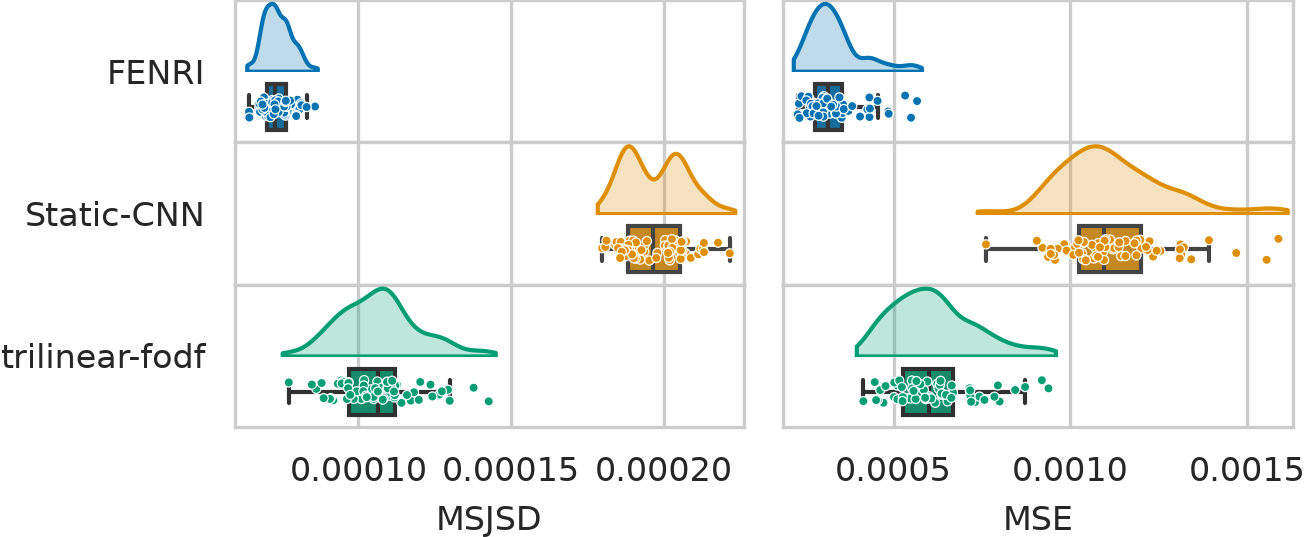

In [ ]:
# Raincloud plot

plot_table = voxelwise_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "FENRI"
plot_table.model[
    plot_table.model.map(lambda n: "static-cnn" in n.casefold())
] = "Static-CNN"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"wm"})]
plt.clf()

with mpl.rc_context(mpl.rc_params()):
    with sns.axes_style(
        "whitegrid", {"font.size": 8.0, "axes.xmargin": 0.0, "axes.ymargin": 0.0}
    ):
        figsize = dict(mpl.rc_params())["figure.figsize"]
        figsize[1] = 2.2
        fig = plt.figure(
            figsize=figsize,
            dpi=dict(mpl.rc_params())["figure.dpi"],
            layout="constrained",
        )
        # fig.set_tight_layout(False)

        unique_models = plot_table.model.unique().tolist()
        unique_metrics = plot_table.metric.unique().tolist()

        colors = sns.color_palette("colorblind", n_colors=len(unique_models))
        color_dict = {
            unique_models[i]: list(colors)[i] for i in range(len(unique_models))
        }
        g = sns.FacetGrid(
            plot_table,
            col="metric",
            row="model",
            row_order=unique_models,
            col_order=unique_metrics,
            # hue="model",
            # palette=color_dict,
            sharex="col",
            sharey="row",
            margin_titles=False,
            despine=False,
            gridspec_kws={
                "hspace": 0.0,
                # "left": 0.03,
                # "right": 0.97,
                # "top": 0.97,
                # "bottom": 0.03,
            },
        )
        g.figure.set_tight_layout(False)
        g.figure.set_figheight(fig.get_figheight())
        g.figure.set_figwidth(fig.get_figwidth())
        g = g.map_dataframe(
            sns.stripplot,
            x="mean_value",
            y="model",
            hue="model",
            palette=color_dict,
            jitter=0.08,
            size=2.2,
            edgecolor="white",
            linewidth=0.3,
            legend=False,
        )
        g = g.map_dataframe(
            sns.boxplot,
            x="mean_value",
            y="model",
            orient="h",
            palette=color_dict,
            hue="model",
            showfliers=False,
            width=0.33,
            linewidth=1.0,
        )
        # sns.despine(g.figure, top=True, right=False, left=False, bottom=True)
        g.set_titles("")

        # Shift all current plots down by 1/4 of the axis size.
        for ax in g.axes.flatten():
            # Shift the scatter plots/points.
            points_artist = list(
                filter(
                    lambda a: isinstance(a, mpl.collections.PathCollection),
                    ax.get_children(),
                )
            )[0]
            curr_offsets = points_artist.get_offsets().data.copy()
            curr_offsets[:, 1] += 1 / 4
            points_artist.set_offsets(curr_offsets)

            # Shift the boxplot artists.
            # This is very hardcoded right now, assumes that these artists correspond
            # to the boxplot only.
            boxplot_artists = list(ax.get_children())[1:8]
            for a in boxplot_artists:
                # The whiskers & median line.
                if isinstance(a, mpl.lines.Line2D):
                    curr_offset = a.get_ydata()
                    curr_offset = curr_offset + 1 / 4
                    a.set_ydata(curr_offset)
                # The "box" body of the plot.
                elif isinstance(a, mpl.patches.Patch):
                    curr_tf = a.get_transform()
                    aff_translate = mpl.transforms.Affine2D().translate(tx=0, ty=1 / 4)
                    new_tf = mpl.transforms.composite_transform_factory(
                        aff_translate, curr_tf
                    )
                    a.set(transform=new_tf)
                else:
                    raise RuntimeError()

        g.figure.canvas.draw()

        for (model, metric), ax in g.axes_dict.items():
            ax.set_ylabel("")
            ax.set_xmargin(0.03)
            if model == unique_models[-1]:
                ax.set_xlabel(metric)

            data = plot_table[
                (plot_table.model == model) & (plot_table.metric == metric)
            ].copy()

            xlim = ax.get_xlim()
            bbox_to_anchor = (xlim[0], -0.5, (xlim[1] - xlim[0]), 1 / 2)

            ax_inset = inset_axes(
                ax,
                width="100%",
                height="100%",
                loc="upper left",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transData,
                borderpad=0,
                axes_kwargs=dict(
                    xticklabels=[],
                    yticklabels=[],
                    frame_on=False,
                    # xmargin=0.05,
                    ymargin=0.05,
                    # xmargin=0,
                    # ymargin=0,
                ),
            )
            ax_inset.set_xlim(*xlim)

            sns.kdeplot(
                data,
                x="mean_value",
                hue="model",
                palette=color_dict,
                common_norm=False,
                fill=True,
                cut=0.5,
                legend=False,
                bw_adjust=0.75,
                ax=ax_inset,
            )
            ax_inset.set_xlabel("")
            ax_inset.set_ylabel("")
            ax_inset.grid(False)

            # tmp viz of bounding box
            # ax.add_patch(
            #     plt.Rectangle(
            #         (bbox_to_anchor[0], bbox_to_anchor[1]),
            #         bbox_to_anchor[2],
            #         bbox_to_anchor[3],
            #         lw=1,
            #         ls="--",
            #         ec="c",
            #         fc="none",
            #         transform=ax.transData,
            #         zorder=100000,
            #     )
            # )

        g
        # g.savefig("quant_results_cloud_plot.pdf", bbox_inches="tight", pad_inches=0.0)
        # g.savefig("quant_results_cloud_plot.svg", bbox_inches="tight", pad_inches=0.0)

### Fixel Metrics

#### Peaks

In [ ]:
peak_metrics_results_table = pd.read_csv("peak_metrics_results.csv")
peak_metrics_results_table

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



========FENRI========
n_target_peaks         1         2         3         4         5
n_pred_peaks                                                    
5               0.374709  0.730021  0.811804  0.839897  0.816264
4               0.334566  0.655104  0.783310  0.832562  0.827122
3               0.292395  0.583278  0.711093  0.808728  0.835264
2               0.255724  0.476427  0.636702  0.728847  0.794672
1               0.133302  0.259903  0.371637  0.459793  0.535488
n_target_peaks         1         2         3         4         5
n_pred_peaks                                                    
5               0.000038  0.000536  0.000418  0.000057  0.000015
4               0.000141  0.001367  0.000931  0.000117  0.000031
3               0.000813  0.007220  0.009661  0.001153  0.000213
2               0.010898  0.153660  0.054162  0.008456  0.002459
1               0.322040  0.236390  0.082716  0.017084  0.006017
========Static-CNN========
n_target_peaks         1         2       

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 432x288 with 0 Axes>

<Figure size 1440x630 with 0 Axes>

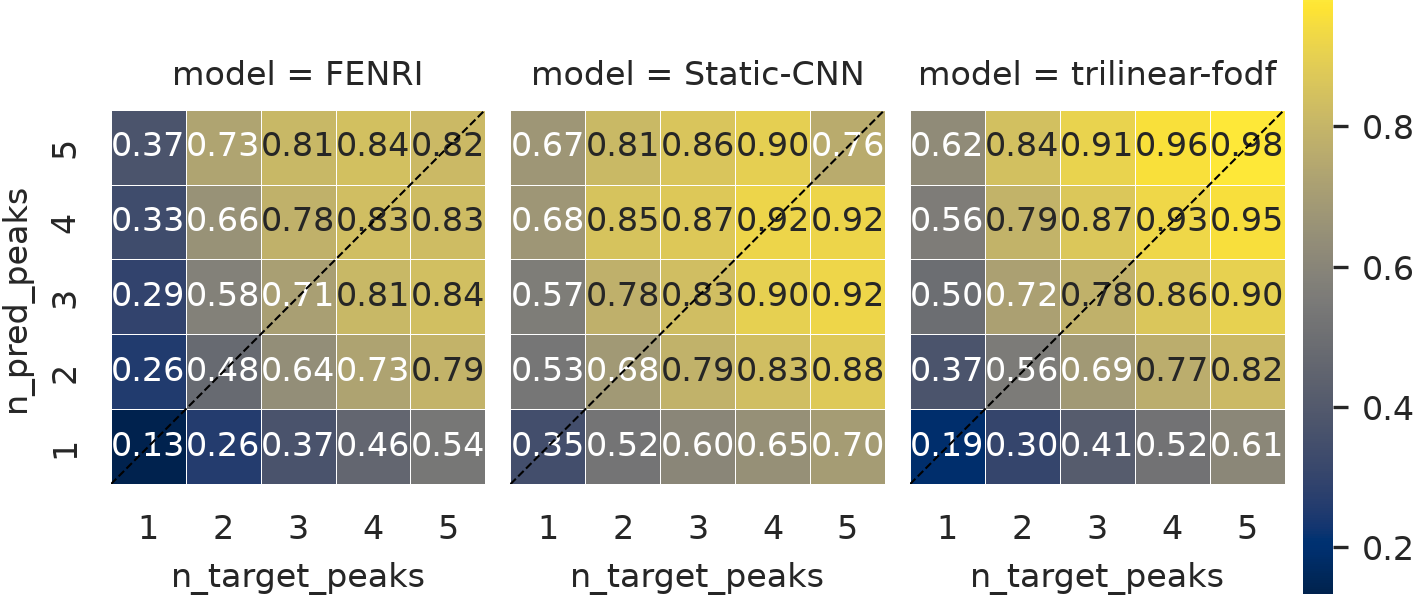

In [ ]:
# Grid of pred vs. ground truth peak distances.
plot_table = peak_metrics_results_table.copy()

plot_table["split"] = plot_table.split.astype("category")
plot_table["subj_id"] = plot_table.subj_id.astype("category")

plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "FENRI"
plot_table.model[
    plot_table.model.map(lambda n: "static-cnn" in n.casefold())
] = "Static-CNN"
# Only take voxels with peak values > 0
plot_table = plot_table[plot_table.n_pred_peaks > 0]
plot_table = plot_table[plot_table.n_target_peaks > 0]
# Compute ratios of each cell.
plot_table["ij_to_total_ratio"] = (
    plot_table.n_vox_with_pred_and_target_peaks / plot_table.n_vox_target_wm
)
plot_table["ij_to_target_i_total_ratio"] = (
    peak_metrics_results_table.n_vox_with_pred_and_target_peaks
    / peak_metrics_results_table.n_vox_with_target_peaks
)
plot_table = plot_table.groupby(["n_target_peaks", "n_pred_peaks", "model"]).mean(
    numeric_only=True
)

plot_table["Perc. Total Vox"] = plot_table["ij_to_total_ratio"]
plot_table["Mean Arc Length"] = plot_table["mean_value"]

plot_table = plot_table.reset_index()


def plot_heatmap(data, index, columns, values, cbar_col_model_name, **kwargs):
    ax = plt.gca()

    model_data = data.pivot(index=index, columns=columns, values=values)
    model_data = model_data.sort_index(axis=0, ascending=False)
    model_name = data.model.unique().tolist()[0]
    if model_name == cbar_col_model_name:
        # kwargs['cbar_ax'] = ax
        kwargs["cbar"] = True
    else:
        kwargs["cbar"] = False

    ax = sns.heatmap(model_data, **kwargs, ax=ax)
    ax = ax.plot([0, 5], [5, 0], color="black", lw=0.5, ls="--", zorder=1000)

    print(f"========{model_name}========")
    print(model_data)
    print(
        data.pivot(index=index, columns=columns, values="Perc. Total Vox").sort_index(
            axis=0, ascending=False
        )
    )
    print("================")


plt.clf()
with mpl.rc_context(mpl.rc_params()):
    with sns.axes_style(
        "whitegrid", {"font.size": 8.0, "axes.xmargin": 0.0, "axes.ymargin": 0.0}
    ):
        figsize = dict(mpl.rc_params())["figure.figsize"]
        figsize[1] = 2.1
        fig = plt.figure(
            figsize=figsize,
            dpi=dict(mpl.rc_params())["figure.dpi"],
            layout="constrained",
        )
        unique_models = plot_table.model.unique().tolist()
        # fig.set_tight_layout(False)
        g = sns.FacetGrid(
            plot_table,
            col="model",
            col_order=unique_models,
            # hue="model",
            # palette=color_dict,
            sharey=True,
            margin_titles=False,
            gridspec_kws={
                "wspace": 0.01,
                #     # "left": 0.03,
                #     # "right": 0.97,
                #     # "top": 0.97,
                #     # "bottom": 0.03,
            },
        )
        g.figure.set_tight_layout(False)
        g.figure.set_figheight(fig.get_figheight())
        g.figure.set_figwidth(fig.get_figwidth())
        # fig.set_tight_layout(False)

        common_vmin = plot_table.mean_value.min()
        common_vmax = plot_table.mean_value.max()
        cbar_col_model_name = unique_models[-1]

        annot_props = dict(
            # bbox=dict(
            #     facecolor=(0, 0, 0, 0),
            # ),
            fontsize=8.0,
        )
        g = g.map_dataframe(
            plot_heatmap,
            index="n_pred_peaks",
            columns="n_target_peaks",
            values="Mean Arc Length",
            annot=True,
            square=True,
            cmap="cividis",
            linewidths=0.2,
            vmin=common_vmin,
            vmax=common_vmax,
            annot_kws=annot_props,
            fmt=".2f",
            # cbar_col_model_name="",
            cbar_col_model_name=cbar_col_model_name,
        )
        # g = g.set_axis_labels("Num Pred. Peaks", "Num Target Peaks")

#### WAAE

In [ ]:
waae_results_table = pd.read_csv("waae_results.csv")
waae_results_table

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



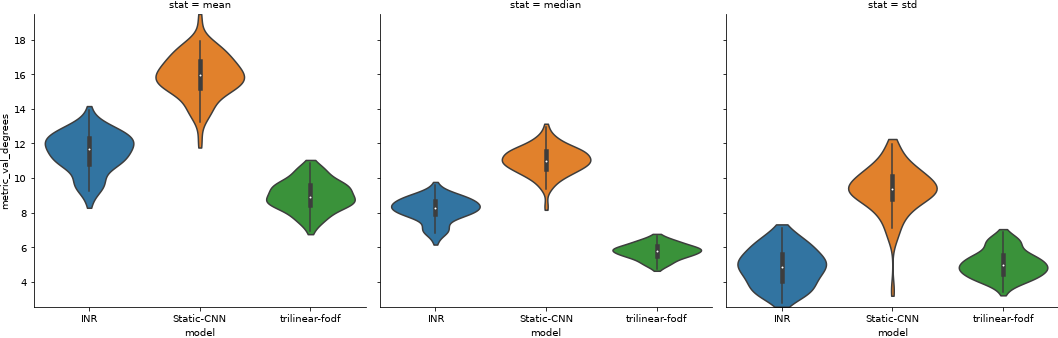

In [ ]:
plot_table = waae_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table.model[
    plot_table.model.map(lambda n: "static-cnn" in n.casefold())
] = "Static-CNN"
plot_table["metric_val_degrees"] = plot_table.metric_val * (180 / np.pi)
sns.catplot(
    plot_table,
    title="WAAE",
    x="model",
    y="metric_val_degrees",
    hue="model",
    kind="violin",
    dodge=False,
    # inner="point",
    col="stat",
    cut=0.5,
)

## Continuous Resolution Animated GIF

In [6]:
multi_res_pred_dir = (
    tmp_results_dir / "2023-05-24T12_03_39__super_res_odf_multi-res_viz"
)

z_slice_coord_mm = 8.625

### INR

In [39]:
vox_resolutions = list()
fodf_fs = list()
for fodf_f in multi_res_pred_dir.glob("*inr-super-res_*mm.nii.gz"):
    fodf_fs.append(fodf_f)
    fname = fodf_f.name
    fname = fname.replace(".nii.gz", "")
    res = fname[-6:].replace("_", "").replace("mm", "")
    res = float(res)
    vox_resolutions.append(res)

res_descend_idx = np.flip(np.argsort(vox_resolutions))
vox_resolutions = [vox_resolutions[i] for i in res_descend_idx]
fodf_fs = [fodf_fs[i] for i in res_descend_idx]

In [40]:
frames = list()
affines_vox2mm = list()
for res, fodf_f in zip(vox_resolutions, fodf_fs):
    fodf_im = nib.load(fodf_f)
    affine_vox2mm = fodf_im.affine
    affine_mm2vox = np.linalg.inv(affine_vox2mm)
    z_plane_coord_mm = torch.tensor([0, 0, z_slice_coord_mm]).flatten()
    z_plane_coord_vox = pitn.affine.coord_transform_3d(
        z_plane_coord_mm.to(torch.float32),
        torch.from_numpy(affine_mm2vox).to(torch.float32),
    )
    target_z_plane_vox = z_plane_coord_vox[-1].item()
    print(res, target_z_plane_vox)
    target_z_plane_vox = round(target_z_plane_vox)

    fodf_slice = fodf_im.slicer[:, :, target_z_plane_vox : (target_z_plane_vox + 1)]
    frames.append(fodf_slice.get_fdata().astype(np.float32))
    affines_vox2mm.append(fodf_slice.affine)

2.0 41.0
1.95 42.0
1.9 43.0
1.85 44.0
1.8 46.0
1.75 47.0
1.7 48.0
1.65 50.0
1.6 51.0
1.55 53.0
1.5 55.0
1.45 57.0
1.4 59.0
1.35 61.0
1.3 63.0
1.25 66.0
1.2 68.0
1.15 71.00000762939453
1.1 75.0
1.05 78.0
1.0 82.0
0.95 86.0
0.9 91.00000762939453
0.85 96.0
0.8 102.0
0.75 109.0
0.7 117.0
0.65 126.0
0.6 137.0
0.55 149.00001525878906
0.5 164.0
0.45 182.00001525878906
0.4 205.0
0.35 234.0
0.3 273.0


In [45]:
print([(f.shape, f.shape[0] / f.shape[1]) for f in frames])

max_width = frames[-1].shape[0]
max_height = frames[-1].shape[1]
print(max_width, max_height)

max_res_affine_vox2mm = affines_vox2mm[-1]
print(max_res_affine_vox2mm)

[((83, 105, 1, 45), 0.7904761904761904), ((85, 107, 1, 45), 0.794392523364486), ((87, 110, 1, 45), 0.7909090909090909), ((89, 113, 1, 45), 0.7876106194690266), ((92, 116, 1, 45), 0.7931034482758621), ((94, 120, 1, 45), 0.7833333333333333), ((97, 123, 1, 45), 0.7886178861788617), ((100, 127, 1, 45), 0.7874015748031497), ((103, 131, 1, 45), 0.7862595419847328), ((107, 135, 1, 45), 0.7925925925925926), ((110, 140, 1, 45), 0.7857142857142857), ((114, 144, 1, 45), 0.7916666666666666), ((118, 150, 1, 45), 0.7866666666666666), ((122, 155, 1, 45), 0.7870967741935484), ((127, 161, 1, 45), 0.7888198757763976), ((132, 168, 1, 45), 0.7857142857142857), ((138, 175, 1, 45), 0.7885714285714286), ((144, 182, 1, 45), 0.7912087912087912), ((150, 190, 1, 45), 0.7894736842105263), ((158, 200, 1, 45), 0.79), ((166, 210, 1, 45), 0.7904761904761904), ((174, 221, 1, 45), 0.7873303167420814), ((184, 233, 1, 45), 0.7896995708154506), ((195, 247, 1, 45), 0.7894736842105263), ((207, 262, 1, 45), 0.790076335877862

In [46]:
dpi = 175

fig, ax = plt.subplots(figsize=(max_width / dpi, max_height / dpi), dpi=dpi)
plt.axis("off")
plt.gca().set_position((0, 0, 1, 1))
ims = list()

for i, (frame, affine_vox2mm) in enumerate(zip(frames, affines_vox2mm)):
    frame = frame[..., 0, 0]
    if frame.shape[0] != max_width or frame.shape[1] != max_height:

        affine_srvox2mm = max_res_affine_vox2mm[np.asarray([0, 1, 3])][
            :, np.asarray([0, 1, 3])
        ]
        affine_lrvox2mm = affine_vox2mm[np.asarray([0, 1, 3])][:, np.asarray([0, 1, 3])]
        affine_srvox2lrvox = np.linalg.inv(affine_lrvox2mm) @ affine_srvox2mm
        frame = scipy.ndimage.affine_transform(
            frame,
            matrix=affine_srvox2lrvox,
            output_shape=(max_width, max_height),
            order=0,
            prefilter=False,
        )

    frame = np.rot90(frame)

    im = ax.imshow(
        frame,
        cmap="gray",
        interpolation="nearest",
        vmin=0,
        vmax=0.4,
        animated=True,
    )
    if i == 0:
        ax.imshow(frame, cmap="gray", interpolation="nearest", vmin=0, vmax=0.4)
    ax.set_xticks([])
    ax.set_yticks([])
    annotation = ax.annotate(
        f"{vox_resolutions[i]:.2f}mm",
        xy=(0.75, 0.9),
        xycoords="figure fraction",
        color="white",
        animated=True,
    )
    ims.append([im, annotation])

ani = mpl.animation.ArtistAnimation(
    fig, ims, interval=145, blit=True, repeat_delay=1000, repeat=True
)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
ani.save("cont_resolution_animation.mp4")
plt.close()

2023-05-30 12:05:34,188 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-05-30 12:05:34,190 - figure size in inches has been adjusted from 3.16 x 4.0 to 3.1542857142857144 x 4.0
2023-05-30 12:05:34,191 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 552x700 -pix_fmt rgba -r 6.896551724137931 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp1w31f4f7/temp.m4v


2023-05-30 12:05:36,367 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-05-30 12:05:36,369 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 552x700 -pix_fmt rgba -r 6.896551724137931 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y cont_resolution_animation.mp4


### Tri-Linear

In [47]:
vox_resolutions = list()
fodf_fs = list()
for fodf_f in multi_res_pred_dir.glob("*tri-linear-super-res_*mm.nii.gz"):
    fodf_fs.append(fodf_f)
    fname = fodf_f.name
    fname = fname.replace(".nii.gz", "")
    res = fname[-6:].replace("_", "").replace("mm", "")
    res = float(res)
    vox_resolutions.append(res)

res_descend_idx = np.flip(np.argsort(vox_resolutions))
vox_resolutions = [vox_resolutions[i] for i in res_descend_idx]
fodf_fs = [fodf_fs[i] for i in res_descend_idx]

In [48]:
frames = list()
affines_vox2mm = list()
for res, fodf_f in zip(vox_resolutions, fodf_fs):
    fodf_im = nib.load(fodf_f)
    affine_vox2mm = fodf_im.affine
    affine_mm2vox = np.linalg.inv(affine_vox2mm)
    z_plane_coord_mm = torch.tensor([0, 0, z_slice_coord_mm]).flatten()
    z_plane_coord_vox = pitn.affine.coord_transform_3d(
        z_plane_coord_mm, torch.from_numpy(affine_mm2vox)
    )
    target_z_plane_vox = z_plane_coord_vox[-1].item()
    print(res, target_z_plane_vox)
    target_z_plane_vox = round(target_z_plane_vox)

    fodf_slice = fodf_im.slicer[:, :, target_z_plane_vox : (target_z_plane_vox + 1)]
    frames.append(fodf_slice.get_fdata().astype(np.float32))
    affines_vox2mm.append(fodf_slice.affine)

2.0 41.0
1.95 41.99999975546813
1.9 42.99999893339056
1.85 44.00000025774981
1.8 45.999998675452304
1.75 47.0
1.7 48.000002243939505
1.65 50.00000072248055
1.6 50.999998286366484
1.55 52.999997692723355
1.5 55.0
1.45 56.999999177867
1.4 58.999999914850505
1.35 60.9999977924206
1.3 62.99999761581412
1.25 66.0
1.2 68.00000238418569
1.15 71.00000279882686
1.1 74.99999837441881
1.05 77.99999772934677
1.0 82.0
0.95 85.99999786678111
0.9 91.00000410609786
0.85 96.00000448787901
0.8 101.99999657273297
0.75 109.0
0.7 117.00000417232522
0.65 125.99999523162823
0.6 137.00000218550355
0.55 149.00000509348772
0.5 164.0
0.45 182.00000821219572
0.4 204.99999694526198
0.35 234.00000834465044
0.3 272.9999942382179


In [49]:
print([(f.shape, f.shape[0] / f.shape[1]) for f in frames])

max_width = frames[-1].shape[0]
max_height = frames[-1].shape[1]
print(max_width, max_height)

max_res_affine_vox2mm = affines_vox2mm[-1]
print(max_res_affine_vox2mm)
print(max_res_affine_vox2mm[(0, 1, 3), (0, 1, 3)])
max_res_affine_vox2mm[np.asarray([0, 1, 3])][:, np.asarray([0, 1, 3])]

[((83, 105, 1, 45), 0.7904761904761904), ((85, 107, 1, 45), 0.794392523364486), ((87, 110, 1, 45), 0.7909090909090909), ((89, 113, 1, 45), 0.7876106194690266), ((92, 116, 1, 45), 0.7931034482758621), ((94, 120, 1, 45), 0.7833333333333333), ((97, 123, 1, 45), 0.7886178861788617), ((100, 127, 1, 45), 0.7874015748031497), ((103, 131, 1, 45), 0.7862595419847328), ((107, 135, 1, 45), 0.7925925925925926), ((110, 140, 1, 45), 0.7857142857142857), ((114, 144, 1, 45), 0.7916666666666666), ((118, 150, 1, 45), 0.7866666666666666), ((122, 155, 1, 45), 0.7870967741935484), ((127, 161, 1, 45), 0.7888198757763976), ((132, 168, 1, 45), 0.7857142857142857), ((138, 175, 1, 45), 0.7885714285714286), ((144, 182, 1, 45), 0.7912087912087912), ((150, 190, 1, 45), 0.7894736842105263), ((158, 200, 1, 45), 0.79), ((166, 210, 1, 45), 0.7904761904761904), ((174, 221, 1, 45), 0.7873303167420814), ((184, 233, 1, 45), 0.7896995708154506), ((195, 247, 1, 45), 0.7894736842105263), ((207, 262, 1, 45), 0.790076335877862

array([[   0.30000001,    0.        ,  -84.625     ],
       [   0.        ,    0.30000001, -122.875     ],
       [   0.        ,    0.        ,    1.        ]])

In [50]:
dpi = 175

fig, ax = plt.subplots(figsize=(max_width / dpi, max_height / dpi), dpi=dpi)
plt.axis("off")
plt.gca().set_position((0, 0, 1, 1))
ims = list()
for i, (frame, affine_vox2mm) in enumerate(zip(frames, affines_vox2mm)):
    frame = frame[..., 0, 0]
    if frame.shape[0] != max_width or frame.shape[1] != max_height:

        affine_srvox2mm = max_res_affine_vox2mm[np.asarray([0, 1, 3])][
            :, np.asarray([0, 1, 3])
        ]
        affine_lrvox2mm = affine_vox2mm[np.asarray([0, 1, 3])][:, np.asarray([0, 1, 3])]
        affine_srvox2lrvox = np.linalg.inv(affine_lrvox2mm) @ affine_srvox2mm
        frame = scipy.ndimage.affine_transform(
            frame,
            matrix=affine_srvox2lrvox,
            output_shape=(max_width, max_height),
            order=0,
            prefilter=False,
        )

    frame = np.rot90(frame)
    im = ax.imshow(
        frame,
        cmap="gray",
        interpolation="nearest",
        vmin=0,
        vmax=0.4,
        animated=True,
    )
    if i == 0:
        ax.imshow(frame, cmap="gray", interpolation="nearest", vmin=0, vmax=0.4)
    ax.set_xticks([])
    ax.set_yticks([])
    annotation = ax.annotate(
        f"{vox_resolutions[i]:.2f}mm",
        xy=(0.75, 0.9),
        xycoords="figure fraction",
        color="white",
        animated=True,
    )
    ims.append([im, annotation])

ani = mpl.animation.ArtistAnimation(
    fig, ims, interval=145, blit=True, repeat_delay=1000, repeat=True
)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
ani.save("tri-linear_cont_resolution_animation.mp4")
plt.close()

2023-05-30 12:10:25,041 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-05-30 12:10:25,042 - figure size in inches has been adjusted from 3.16 x 4.0 to 3.1542857142857144 x 4.0
2023-05-30 12:10:25,043 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 552x700 -pix_fmt rgba -r 6.896551724137931 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp0l3_lnnv/temp.m4v


2023-05-30 12:10:27,021 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-05-30 12:10:27,022 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 552x700 -pix_fmt rgba -r 6.896551724137931 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y tri-linear_cont_resolution_animation.mp4
